# Questão 5  
  
## Bibliotecas e Constantes

In [543]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import operator
import random
from numpy.random import randint
from scipy.stats.stats import pearsonr

## Definir o grafo

In [544]:
data = pd.read_csv('miseraveis.csv')

In [545]:
maxi = max(data['from'].max(),data['to'].max())
n = maxi + 1
vertices = list(range(n))

In [546]:
graph = nx.DiGraph()
graph.add_nodes_from(vertices)

In [547]:
for index, row in data.iterrows():
    graph.add_edge(row['from'], row['to'])

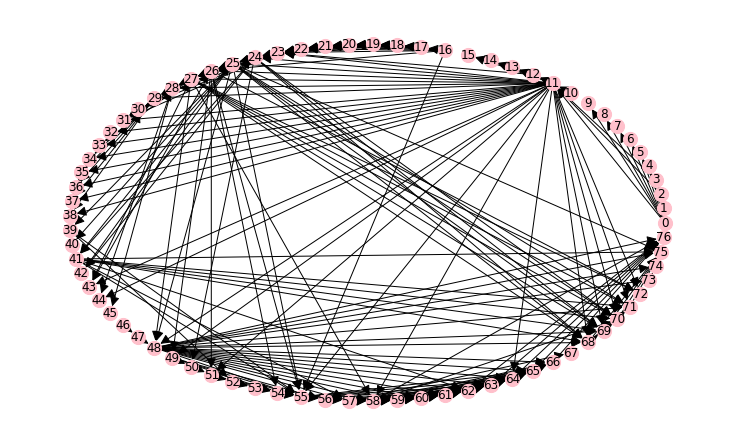

In [548]:
plt.figure(figsize=(10,6))

options = {
    'node_color': 'pink',
    'node_size': 200,
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 20,
}

npos = nx.circular_layout(graph,scale=1)

nx.draw(graph,pos = npos, with_labels=True, **options, arrows=True)
plt.show()

## Algoritmo

Criar a matriz de adjacências

In [549]:
A = nx.to_numpy_matrix(graph,nodelist=sorted(graph.nodes()))

Cria a matriz de probabilidade de transição

In [550]:
P = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        
        # se a soma da linha for >0
        if(np.sum(A[i,:]) > 0):
            P[i,j] = A[i,j]/np.sum(A[i,:])
            
        # se a soma da linha for  = 0 , todos os valores recebem 1/n
        else:
            P[i,j] = 1/n


In [551]:
def check_sum_lines(n, P):
        
    for i in range(n):
        for j in range(n):

            if(not math.isclose(np.sum(P[i,:]),1)):
                print('A matriz não é estocástica')
                return False
    print('A matriz é estocástica')
    return True
    

In [552]:
check_sum_lines(n, P)

A matriz é estocástica


True

Ajuste ergódico e criação da matriz google

In [553]:
G = np.zeros((n,n))
# número utilizado pelo google para fazer o page rank
alpha = 0.85

for i in range(n):
    for j in range(n):
        G[i,j] = alpha*P[i,j] + (1-alpha)/n
print(G)

[[0.00194805 0.08694805 0.08694805 ... 0.00194805 0.00194805 0.00194805]
 [0.01298701 0.01298701 0.01298701 ... 0.01298701 0.01298701 0.01298701]
 [0.00194805 0.00194805 0.00194805 ... 0.00194805 0.00194805 0.00194805]
 ...
 [0.01298701 0.01298701 0.01298701 ... 0.01298701 0.01298701 0.01298701]
 [0.01298701 0.01298701 0.01298701 ... 0.01298701 0.01298701 0.01298701]
 [0.01298701 0.01298701 0.01298701 ... 0.01298701 0.01298701 0.01298701]]


Agora que temos uma matriz aperíodica e irredutível, podemos calcular a distribuiçao estacionária que será nosso page rank

In [554]:
# Cálculo dos autovetores e autovalores
eigvals, eigvecs = np.linalg.eig(G.T)
# Encontrar o autovetor cujo autovalor é próximo de 1
pi = eigvecs[:,np.isclose(eigvals, 1)]

# normalizacao
stationary_dist = (pi / pi.sum()).real

# cria um dict com essa distribuiçao
stationary_dict = {}
for i in range(n):
    
    stationary_dict[i] = stationary_dist[i][0]
    


In [555]:
print(f'O vértice mais importante é o {stationary_dist.argmax()} com valor {stationary_dist.max()}')
print(f'O vértice menos importante é o {stationary_dist.argmin()} com valor {stationary_dist.min()}')


O vértice mais importante é o 76 com valor 0.06610303793076111
O vértice menos importante é o 0 com valor 0.0057963843538979066


Plota os resultados baseado na distribuiçao estacionária, quanto maior o nó mais importante ele é, ou seja, o valor da distribuiçao estacionária encontrada é maior

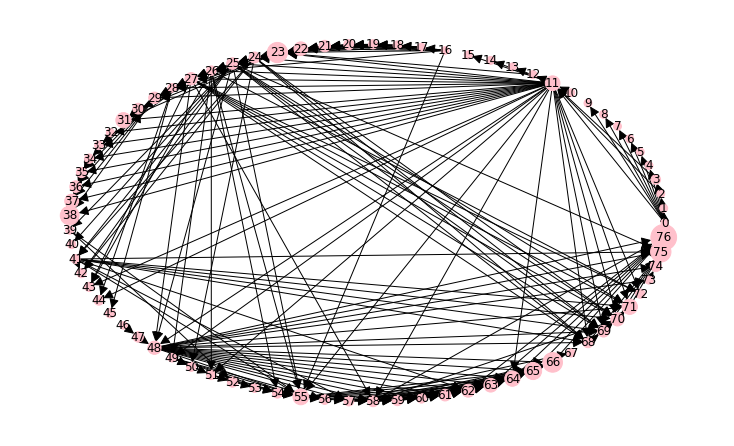

In [556]:
plt.figure(figsize=(10,6))
npos = nx.circular_layout(graph,scale=1)

options = {
    'node_color': 'pink',
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 20,
}

s = stationary_dist*10000
nx.draw(graph,pos = npos,**options, with_labels=True, node_size = s, arrows=True)
plt.draw()
plt.show()

Comparando nossos cálculos com a funçao já existente na biblioteca networkx

In [557]:
rank_node = nx.pagerank(graph)

closeness = []

for i in range(n):
    
   closeness.append(math.isclose(stationary_dict[i],rank_node[i],rel_tol = 0.0001))

if(all(closeness)):
    print('Sao similares')
else:
    print('Nao sao tao similares')


Sao similares


## Caminhada aleatória

In [558]:
steps = [5,10,20,50,100,200,1000,3000]

results = []

for j,s in enumerate(steps):
    visit = {} #initialise the value for all nodes as 0
    for i in range(n):
        visit[i] = 0

    for node in graph.nodes():

        visit[node] = visit[node]+1
        
        random_node = node
        
        for i in range(s):
    
            # encontra todas os possíveis vizinhos do vertice
            list_for_nodes = list(graph.neighbors(random_node))

            # caso nao tenha nenhum vizinho, pula para um próximo nó aleatório
            if len(list_for_nodes)==0:

                random_node = randint(0, n)
                visit[random_node] = visit[random_node]+1

            else:
                # escolhe o próximo passo randomicamente dentre os possiveis vizinhos
                random_node = random.choice(list_for_nodes)
                visit[random_node] = visit[random_node] + 1
            
    results.append(list(visit.values()))
            

Tem uma grande correlação, os dez itens mais importantes são os mesmos, com algumas ordens trocadas mas muito por conta dos valores serem próximos. 

In [559]:
sorted_stationary = sorted(stationary_dict.items(), key=operator.itemgetter(1),reverse=True)
sorted_stationary = [x[0] for x in sorted_stationary]

sorted_visit = sorted(visit.items(), key=operator.itemgetter(1),reverse=True)
sorted_visit = [x[0] for x in sorted_visit]

print('-- Top 10 mais visitados step = 3000 -- ')
print(f'De acordo com a distribuição estacionária : {sorted_stationary[:10]}')
print(f'De acordo com o vetor de visitados : {sorted_visit[:10]}\n')

print('-- Comparação dos valores para os nós 31 e 71 step = 3000 --')
print(f'31 - Vistados: {visit[31]} Distribuição Estacionária: {stationary_dict[31]}')
print(f'71 - Vistados: {visit[71]} Distribuição Estacionária: {stationary_dict[71]}')


-- Top 10 mais visitados step = 3000 -- 
De acordo com a distribuição estacionária : [76, 75, 23, 66, 38, 65, 55, 71, 64, 31]
De acordo com o vetor de visitados : [76, 75, 66, 23, 38, 65, 71, 31, 64, 55]

-- Comparação dos valores para os nós 31 e 71 step = 3000 --
31 - Vistados: 5769 Distribuição Estacionária: 0.02305238305699902
71 - Vistados: 5876 Distribuição Estacionária: 0.023367027401030947


Para ver a relação entre o vetor de visitados e o a distribuição estacionária (Page Rank) calculamos a correlação de Pearson 

In [560]:
pearson = []

for i,_ in enumerate(steps):
    
    x,y = pearsonr(list(stationary_dict.values()),results[i])
    pearson.append(x)
    

In [561]:
pearson 

[0.9322907958354039,
 0.9643179078290314,
 0.9767626934212731,
 0.9860783570786531,
 0.9861539009984956,
 0.9927627612244929,
 0.994644503767155,
 0.9957649014716047]

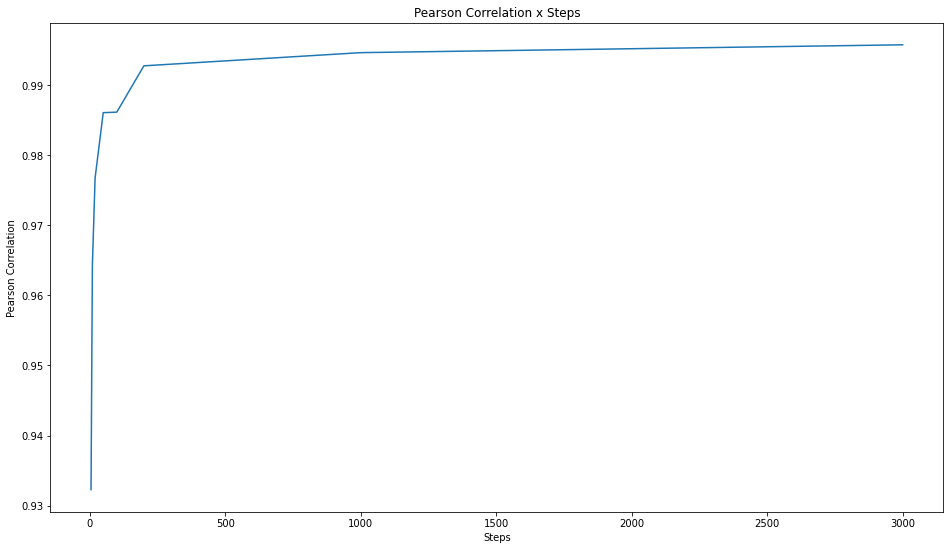

In [562]:
plt.figure(figsize=(16,9))

x = [item * n for item in steps]
x = steps
plt.xlabel("Steps")
plt.ylabel("Pearson Correlation")

# plt.xticks(x)
plt.plot(x, pearson)
plt.title('Pearson Correlation x Steps')

plt.show()